In [1]:
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as smoi
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

# CSCA 5622 Supervised Learning Final Project: Predicting Student Performance
## Project Description
For this project, the goal is to predict student performance using supervised learning techniques, specifically focusing on identifying key factors that influence academic outcomes. The task is framed as a regression problem since we aim to predict a continuous variable, such as students' final grades or test scores, based on various input features such as demographic information, study habits, and socio-economic factors. The project involves performing Exploratory Data Analysis (EDA) to identify relationships between different features and the target variable, followed by applying machine learning algorithms to build predictive models. This is important because understanding the factors that affect student performance can help educators and institutions tailor interventions to improve learning outcomes, and the goal is to develop a model that provides accurate predictions to support data-driven decision-making in educational settings.
## Data Description

Data sets: <br> https://www.kaggle.com/datasets/lainguyn123/student-performance-factors <br>
<br> planning on using one above <br>
<br>This dataset which was sourced from kaggle.com provides a comprehensive overview of various factors affecting student performance in exams. It includes information on study habits, attendance, parental involvement, and other aspects influencing academic success. This data is stored in a CSV file and contains 20 features with 6,607 records. Here is a description of all the features in the dataset:<br>
| Feature      | Description     |
| ------------- | ------------- |
| Hours_Studied	| Number of hours spent studying per week. |
| Attendance	|	Percentage of classes attended. |
| Parental_Involvement	|	Level of parental involvement in the student's education (Low, Medium, High). |
| Access_to_Resources	|	Availability of educational resources (Low, Medium, High). |
| Extracurricular_Activities	|	Participation in extracurricular activities (Yes, No). |
| Sleep_Hours	|	Average number of hours of sleep per night. |
| Previous_Scores	|	Scores from previous exams. |
| Motivation_Level	|	Student's level of motivation (Low, Medium, High). |
| Internet_Access	|	Availability of internet access (Yes, No). |
| Tutoring_Sessions	|	Number of tutoring sessions attended per month. |
| Family_Income	|	Family income level (Low, Medium, High). |
| Teacher_Quality	|	Quality of the teachers (Low, Medium, High). |
| School_Type	|	Type of school attended (Public, Private). |
| Peer_Influence	|	Influence of peers on academic performance (Positive, Neutral, Negative). |
| Physical_Activity	|	Average number of hours of physical activity per week. |
| Learning_Disabilities	|	Presence of learning disabilities (Yes, No). |
| Parental_Education_Level	|	Highest education level of parents (High School, College, Postgraduate). |
| Distance_from_Home	|	Distance from home to school (Near, Moderate, Far). |
| Gender	|	Gender of the student (Male, Female). |
| Exam_Score	|	Final exam score. |




<br>https://www.kaggle.com/datasets/souradippal/student-performance-prediction<br>

## Data Import
Next we will import the data from kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

print("Path to dataset files:", path)
data_path = os.path.join(path, "StudentPerformanceFactors.csv")  # Adjust the filename based on the actual dataset
df = pd.read_csv(data_path)
df.info()   # Data types and non-null count
df.describe()  # Summary statistics

Path to dataset files: C:\Users\marty\.cache\kagglehub\datasets\lainguyn123\student-performance-factors\versions\8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   o

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


## Data Cleaning
First, I looked into missing data. I noticed that there were 3 columns that contained missing values: Teacher_Quality with 78 missing values, Parental_Education_Level with 90 missing values, and Distance_from_Home with 67 missing values. I then noticed that there were only 229 rows that contained at least one missing value, thus I dropped all mising values since that accounts for less than 3.5 percent of the total dataset. Next, I looked for outliers. The only three columns that contained outliers were Hours_Studied, Tutoring_Sessions, and Exam_score. It is important to keep all outliers in this problem. In the Exam_Score varaible there are a lot of outliers for higher scores. Since this is the target variable, we want to see if we can expalin how students scored well on exams, thus we do not wantr to remove these samples. For Hours_Studied and Tutoring_Sessions it is helpful to also keep these outliers to see if those outliers impacted some of the low or high outliers in the Exam_Score. After that, every column was checked for imbalance. The first step in checking for imbalance is to check how many unique values are in each column. After that, the data type was determined, if the variable is continous then the data was split into 10 bins. If there were less than 4 unique values in the column we used a threshold of 75 percent, otherwise a threshold of 50 percent was used. There were only two columns that jad values exceding therre threshold: Internet_Access and Learning_Disabilities. This is not an issue as these two factors may be used to to explain outliers, I pressume the low outliers. In conclusion, this dataset was already preety clean to begin with and I do not forsee and difficulties due to the updated state of the data.

In [3]:
print(df.isnull().sum())
print(F"Number of rows with missing values: {df.isnull().any(axis=1).sum()}")
df = df.dropna()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64
Number of rows with missing values: 229


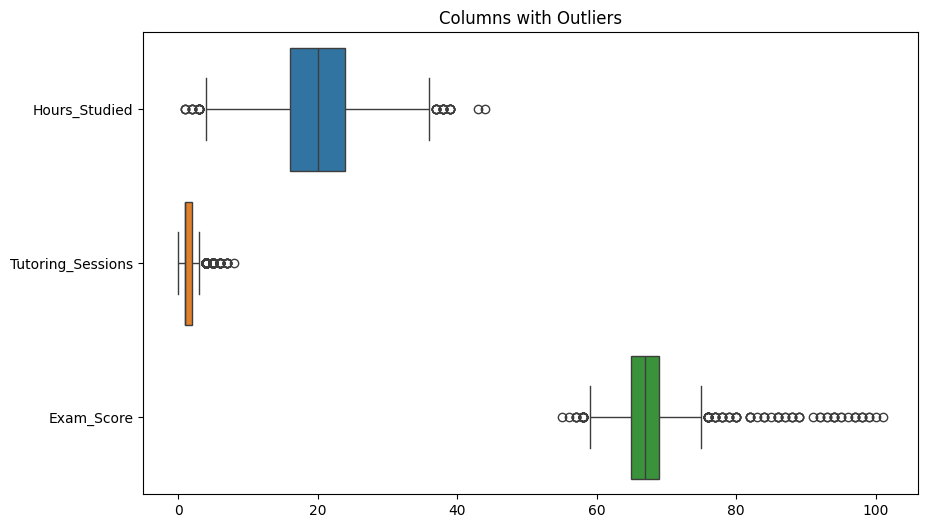

In [4]:
def detect_outliers_iqr(df):
    outlier_info = {}
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:  # Iterate over numerical columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get the outliers in the column
        outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # If there are outliers, store the column name
        if not outliers_in_column.empty:
            outlier_info[column] = len(outliers_in_column)
    
    return outlier_info

# Detect columns with outliers
outlier_info = detect_outliers_iqr(df)

# Visualize columns with outliers using boxplots
if outlier_info:
    # Filter columns that have outliers
    columns_with_outliers = list(outlier_info.keys())
    
    # Create a boxplot for each column with outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[columns_with_outliers], orient='h')
    plt.title('Columns with Outliers')
    plt.show()
else:
    print("No columns contain outliers.")

In [5]:
def check_imbalance(df):
    imbalance_info = {}

    for column in df.columns:
        # Calculate the number of unique values in the column
        num_unique = df[column].nunique()

        # Set the threshold based on the number of unique values
        if num_unique > 4:
            threshold = 0.5  # 50% threshold for columns with more than 4 unique values
        else:
            threshold = 0.75  # 75% threshold for columns with 4 or fewer unique values

        if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
            # For categorical columns
            value_counts = df[column].value_counts(normalize=True)  # normalized to get proportions
            if any(value_counts > threshold):  # Check if any value exceeds the threshold
                imbalance_info[column] = value_counts[value_counts > threshold]

        elif pd.api.types.is_numeric_dtype(df[column]):
            # For numerical columns, we'll bin the values
            # For simplicity, we use pd.cut to bin the data into 10 equal-width bins.
            binned = pd.cut(df[column], bins=10)
            value_counts = binned.value_counts(normalize=True)  # normalized to get proportions
            if any(value_counts > threshold):  # Check if any bin exceeds the threshold
                imbalance_info[column] = value_counts[value_counts > threshold]

        elif pd.api.types.is_bool_dtype(df[column]):
            # For boolean columns, similar to categorical
            value_counts = df[column].value_counts(normalize=True)
            if any(value_counts > threshold):
                imbalance_info[column] = value_counts[value_counts > threshold]
    
    return imbalance_info

# Run the function and check for imbalance
imbalance_columns = check_imbalance(df)

# Display the columns where imbalance is found
if imbalance_columns:
    print("Imbalance found in the following columns:")
    for col, values in imbalance_columns.items():
        print(f"{col}: {values}")
else:
    print("No imbalance found where a value exceeds the threshold.")

Imbalance found in the following columns:
Internet_Access: Internet_Access
Yes    0.923957
Name: proportion, dtype: float64
Learning_Disabilities: Learning_Disabilities
No    0.895265
Name: proportion, dtype: float64


C:\Users\marty\AppData\Local\Temp\ipykernel_17388\2969022268.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\2969022268.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\2969022268.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\2969022268.py:14: DeprecationWarning: is_categorical_

##  Exploratory Data Analysis
We perfomred three main steps in this analysis: Variable distrubution exploration, feature importance, and correlation matrix
### Variable Distribution Exploration
#### Numeric columns
For the numerical columns we created a histogram and boxplot for each variable. Here are the findings for each variable: 
<br> 
- **Hours_Studied:** This distribution is almost perfectly normal with a median of 20 hours studied and 5 outliers to the right and 3 outliers to the left.
- **Attendance:** This distribution shows some uniformity with every 3rd bin having a lower distribution then the rest and a median of 80.
- **Sleep_Hours:** This distrribution would be considered normal with a median of 7 hours slept.
- **Previous_Scores:** This distribution shows some uniformity with every 3rd bin having a higher distribution then the rest and a median of 75.
- **Tutoring_Sessions:** This distribution has a positive skew with 5 outliers to the right. 
- **Physical_Activity:** This distrribution would be considered normal with a median of 3 hours of physical activity.
- **Exam_Score:** This distribution has a positive skew a few outliers to the left and a large number of outliers to the right
#### Categorical Columns
- **Parental_Involvement:** This column has 3 unique values with the "Medium" value being the mode by a considerable amount.
- **Access_to_Reseources:** This column has 3 unique values with the "Medium" value being the mode by a considerable amount.
- **Extracurricular_Activities:** This column has 2 unique values with the "Yes" value being the model by a moderate amount.
- **Motivation_Level:** This column has 3 unique values with the "Medium" value being the mode by a considerable amount.
- **Internet_Access:** This column has 2 unique values with the overwhelming majority being "No"
- **Family_Income:** This column has 3 unique values  with the "Low" and "Medium" having similar counts with the "High" value having a significantly lower count
- **Teacher_Quality:** This column has 3 unique values with the "Medium" value being the mode by a considerable amount.
- **School_Type:** This column has 2 unique values with the "Public" value being the mode by a considerable amount.
- **Peer_Influence:** This column has 3 unique values with the "Positive" and "Neutral" having similar counts with the "Negative" value having a significantly lower count
- **Learning_Disabilities:** This column has 2 unique values with the overwhelming majority being "No"
- **Parental_Education_Level:** This column has 3 unique values with the "High School" value being the mode by a considerable amount.
- **Distance_from_Home:** This column has 3 unique values with the "Near" value being the mode by a considerable amount.
- **Gender:** This column has 2 unique values with the "Male" value being the model by a moderate amount.

#### Feature Importance
The first step here was to encode categorial variables. For variables Parental_Involvement, Access_to_Resources, Motivation_Level, Family_Income, Teacher_Quality, Peer_Influence, Parental_Education_Level, and Distance_from_Home I used label encoding as these varaibles have an ordinal nature.  While for School_Type, Gender, Learning_Disabilities, Extracurricular_Activities, and Internet_Access I used hot encoding as these are binary variables.
The most important features are Attendance, Hours_studied, and Previous Scores. The least important features are Learning_Disabilities and Internet Access. Although those two features had imbalance, so if we do not include those features then the least important features are School_type, Gender, and Extracurricular_Activities. 
#### Correlation Matrix
There looks to be signifigant correlation between some of the features and the target, but no correlation between the features. Thus, we do not have to worry about multicollinearity 

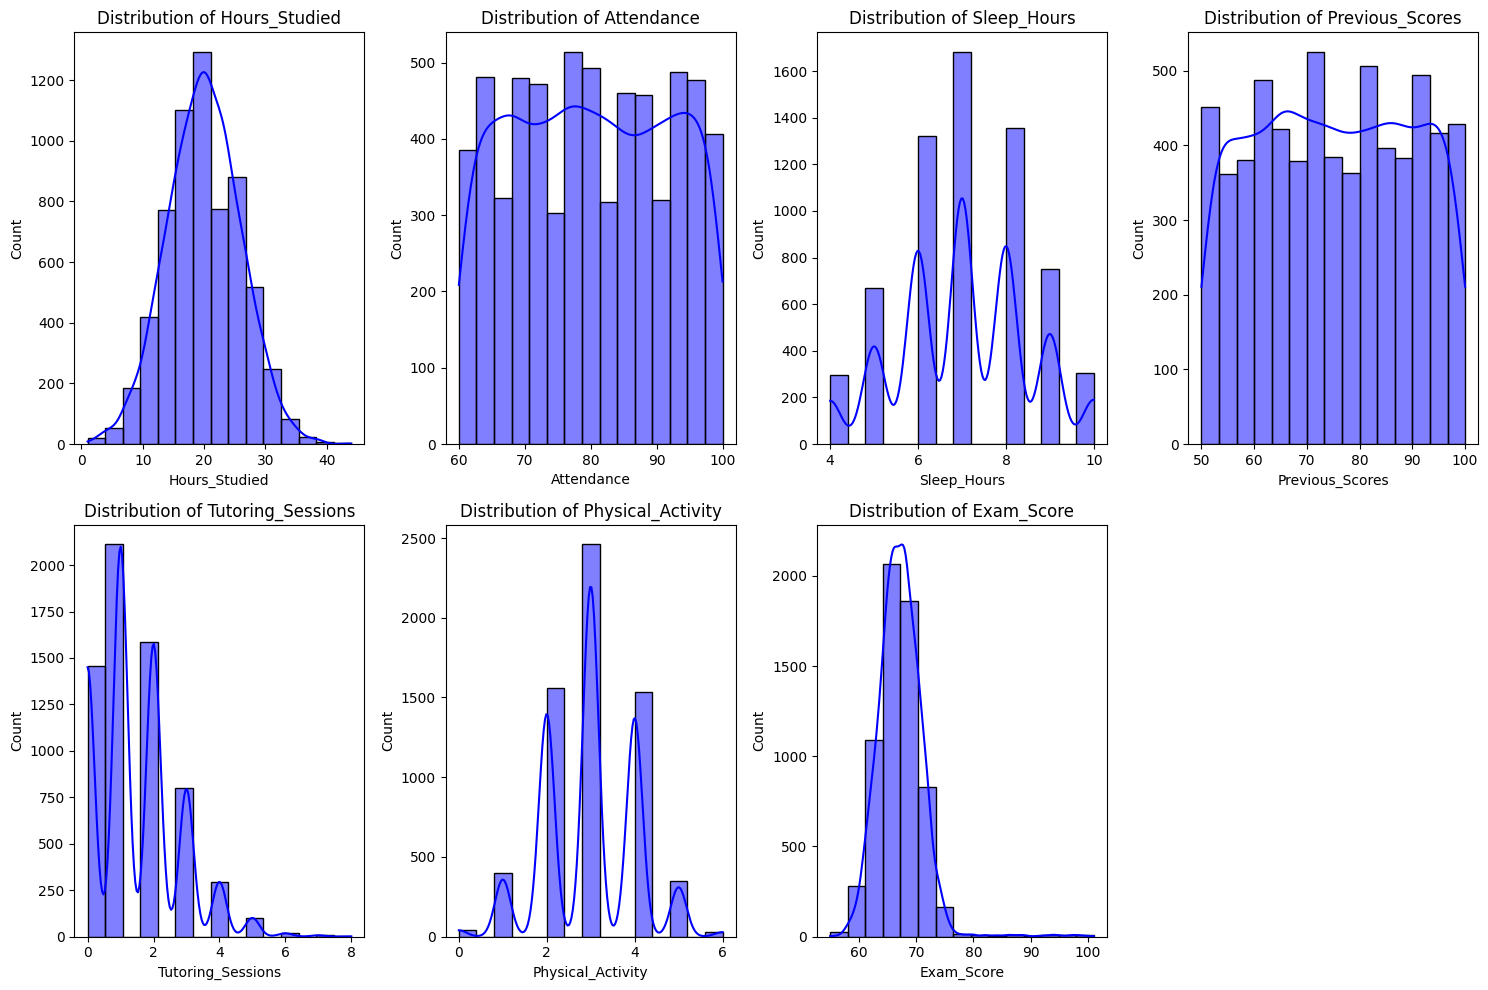

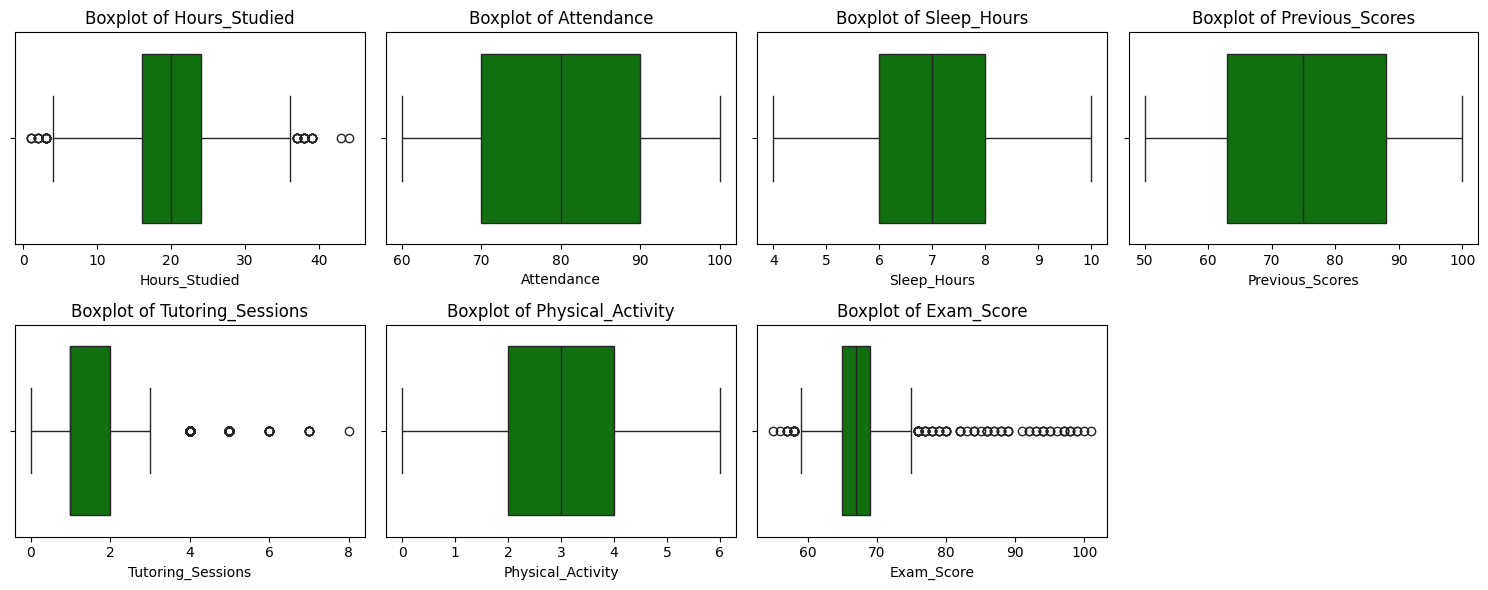

In [6]:
# Histogram for numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2 + 1, i)
    sns.histplot(df[col], kde=True, bins=15, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplot for numerical columns to detect outliers
plt.figure(figsize=(15, 6))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2 + 1, i)
    sns.boxplot(x=df[col], color='green')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Categorical columns summary:

Parental_Involvement value counts:
Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources value counts:
Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities value counts:
Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level value counts:
Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access value counts:
Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income value counts:
Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality value counts:
Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type value counts:
School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence value counts:
Peer_Influence
Positiv

C:\Users\marty\AppData\Local\Temp\ipykernel_17388\3143657395.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2')
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\3143657395.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2')
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\3143657395.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2')
C:\Users\marty\AppData\Local\Temp\ipykernel_17388\3143657395.py:14: FutureWarning: 

Passing `palette` without assigni

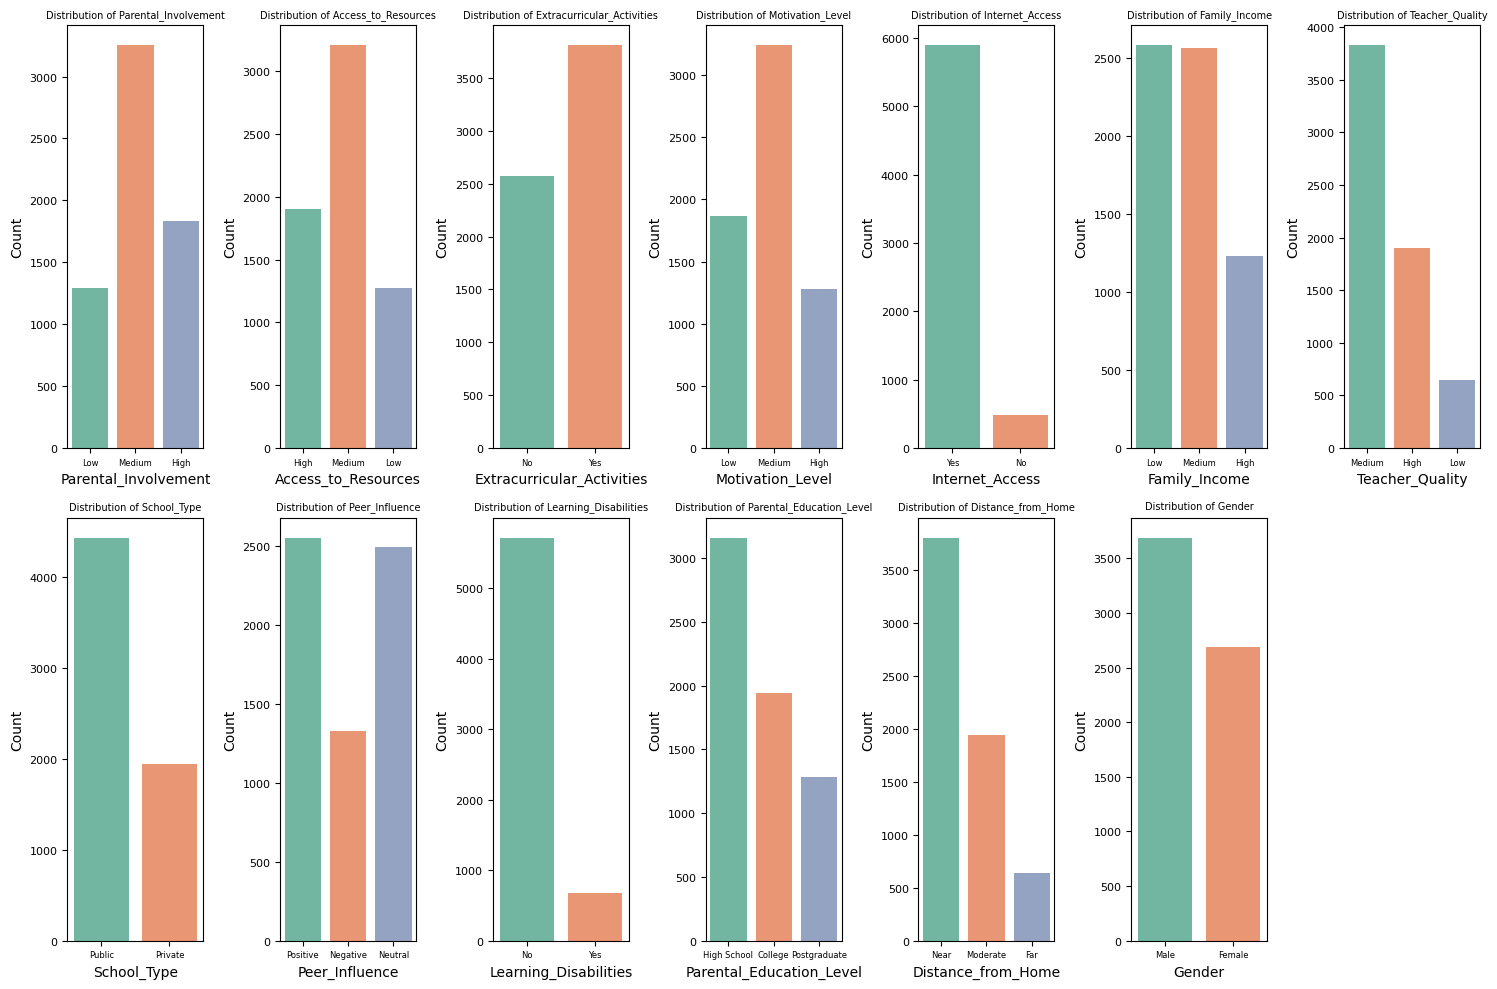

In [7]:
# Categorical columns in the DataFrame
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

print("Categorical columns summary:")
for col in categorical_columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())

# Bar plot for categorical columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, len(categorical_columns)//2 + 1, i)
    sns.countplot(x=df[col], palette='Set2')
    
    # Set title with custom font size
    plt.title(f'Distribution of {col}', fontsize=7)
    
    # Set x and y axis labels font size
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    
    # Set tick label font size
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


      Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0                23          84                  Low                High   
1                19          64                  Low              Medium   
2                24          98               Medium              Medium   
3                29          89                  Low              Medium   
4                19          92               Medium              Medium   
...             ...         ...                  ...                 ...   
6602             25          69                 High              Medium   
6603             23          76                 High              Medium   
6604             20          90               Medium                 Low   
6605             10          86                 High                High   
6606             15          67               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
0                     

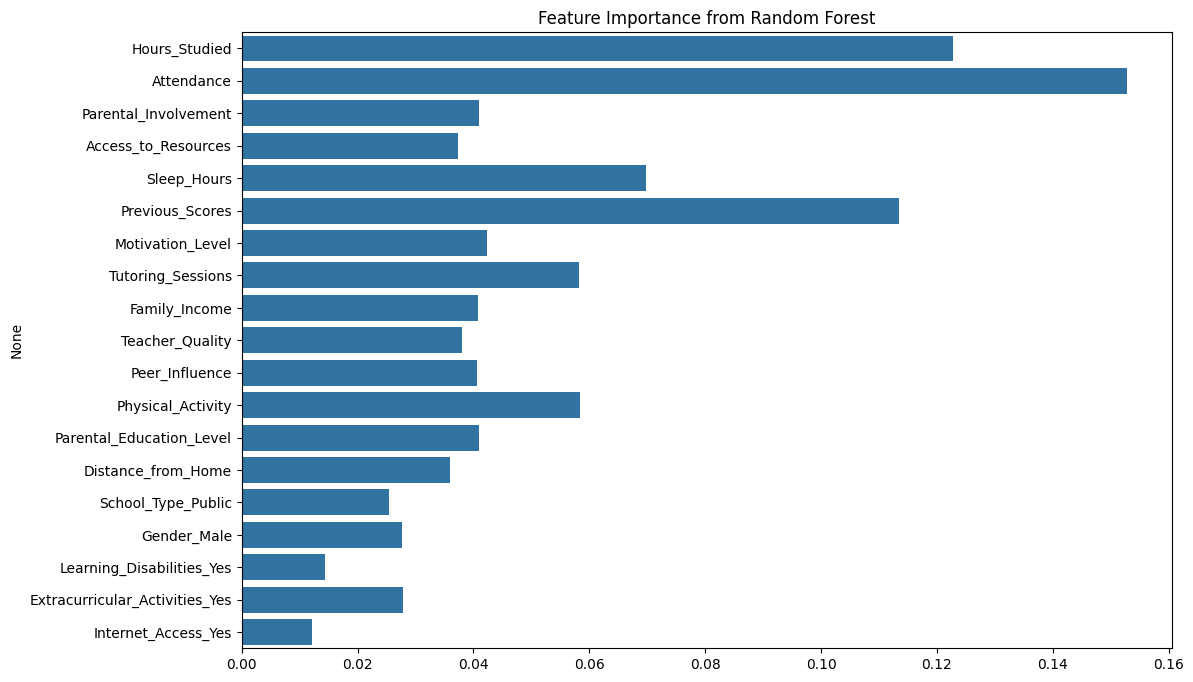

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
#categorical_columns = df.select_dtypes(include=['object', 'category']).columns

##for col in categorical_columns:
    #df[col] = label_encoder.fit_transform(df[col])
encoding_dict = {
    'Parental_Involvement': {'Low': 1, 'Medium': 2, 'High': 3},
    'Access_to_Resources': {'Low': 1, 'Medium': 2, 'High': 3},
    'Motivation_Level': {'Low': 1, 'Medium': 2, 'High': 3},
    'Family_Income': {'Low': 1, 'Medium': 2, 'High': 3},
    'Teacher_Quality': {'Low': 1, 'Medium': 2, 'High': 3},
    'Peer_Influence': {'Negative': 1, 'Neutral': 2, 'Positive': 3},
    'Parental_Education_Level': {'High School': 1, 'College': 2, 'Postgraduate': 3},
    'Distance_from_Home': {'Near': 1, 'Moderate': 2, 'Far': 3}
}
print(df)

# Apply custom encoding to categorical variables
for column, mapping in encoding_dict.items():
    df[column] = df[column].map(mapping)

# 'School_Type', 'Gender', 'Learning_Disabilities', 'Extracurricular_Activities', 'Internet_Access'
df_encoded = pd.get_dummies(df, columns=['School_Type', 'Gender', 'Learning_Disabilities', 'Extracurricular_Activities', 'Internet_Access' ], drop_first=True)
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)
print(df_encoded)

# Assuming 'target' is the target variable, and df has both numeric and categorical columns
X = df_encoded.drop('Exam_Score', axis=1)  # Features
y = df_encoded['Exam_Score']  # Target

# Fit a Random Forest model to get feature importance
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# Plot feature importances
feature_importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance from Random Forest')
plt.show()

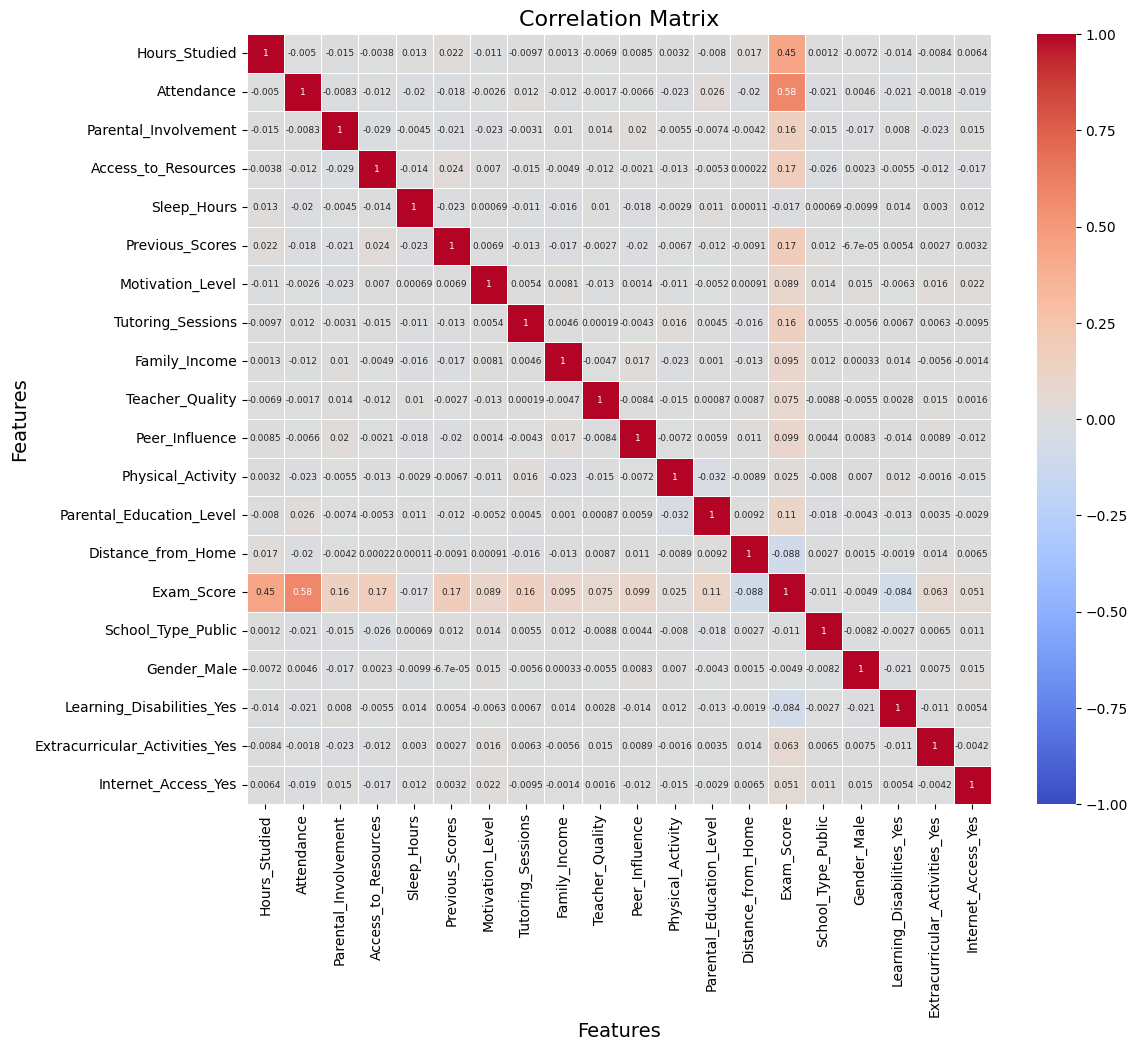

In [9]:
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))  # Adjust the size of the heatmap
sns.heatmap(correlation_matrix, 
            annot=True,               # Enable annotations (the numbers inside the boxes)
            cmap='coolwarm',          # Color map
            vmin=-1, vmax=1,          # Set the color scale range
            linewidths=0.5,           # Border between the boxes
            annot_kws={'size': 6.5})   # Adjust font size of the annotations (numbers inside the boxes)

# Title and axis labels with adjustable font sizes
plt.title('Correlation Matrix', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

## Models
Before we run any models we want to check for multicolinearity using VIF. Here we see that the VIF is nearly 1 for all feautures meaning that there is no multicolinearity. To prepare data for our models, we split the data into a train and test dataset using an 80/20 split. The two strategies that will be used are lasso regression with hyperparameter tuning for alpha and linear regression. We hyper tune with an alpha ranging from 10^-4 to 10. As well, we use a 5-fold cross validation to evaluate the model. We then fit the model with the best alpha found and extract the coefficents. We notice that Access_to_Resources and Parental_Involvement are the most important feautures, while Gender_Male and Sleep_Hours are the least important features. After that, we train the simplier linear regression model using 5 fold cross validation. Finally, we evaluate both models and notice that the Lasso Regression model performed better based on MSE. 

In [10]:
# Check for Multicollinearity using VIF
#Add constant (intercept) to the features
X_const = sm.add_constant(X)
# Step 3: Initialize the VIF dataframe
vif_data = pd.DataFrame()
# Step 4: Calculate VIF for each feature (including the constant)
vif_data["feature"] = X_const.columns  # Use X_const.columns to match the new column names
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso Regression with hyperparameter tuning for alpha
lasso = Lasso()
# Range of alpha values to try using logspace for a wide range
param_grid = {'alpha': np.logspace(-4, 1, 10)}  # Alpha values from 10^-4 to 10^1
grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# Fit the model to the training data
grid_search_lasso.fit(X_train, y_train)
# Best alpha found by GridSearchCV
best_alpha_lasso = grid_search_lasso.best_params_['alpha']
best_lasso_model = grid_search_lasso.best_estimator_
print(f"Best alpha for Lasso Regression: {best_alpha_lasso}")
# Get the coefficients of the best model
coefficients = best_lasso_model.coef_
# Create a DataFrame to display the feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})
# Calculate the absolute value of the coefficients to rank by importance
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
# Sort by absolute value of coefficients (most important features first)
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
# Display the most important features
print("\nFeature Importance (by Lasso Coefficients):")
print(feature_importance)

# Cross-validation for Linear Regression
linear_regression = LinearRegression()
cv_scores_lr = cross_val_score(linear_regression, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score_lr = np.mean(cv_scores_lr)
print(f"Linear Regression - Mean CV Score (Negative MSE): {mean_cv_score_lr}")

# Evaluate Lasso Regression model on the test set
y_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Evaluate Linear Regression model on the test set
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Compare the models
if mse_lasso < mse_lr:
    print("Lasso Regression is the better model based on MSE.")
    print(f"Lasso MSE: {mse_lasso}, R²: {r2_lasso}")
    print(f"Linear Regression MSE: {mse_lr}, R²: {r2_lr}")
else:
    print("Linear Regression is the better model based on MSE.")
    print(f"Linear Regression MSE: {mse_lr}, R²: {r2_lr}")
    print(f"Lasso MSE: {mse_lasso}, R²: {r2_lasso}")


                           feature         VIF
0                            const  212.847532
1                    Hours_Studied    1.002064
2                       Attendance    1.004210
3             Parental_Involvement    1.004267
4              Access_to_Resources    1.003600
5                      Sleep_Hours    1.002749
6                  Previous_Scores    1.003785
7                 Motivation_Level    1.002322
8                Tutoring_Sessions    1.001602
9                    Family_Income    1.002318
10                 Teacher_Quality    1.001424
11                  Peer_Influence    1.002353
12               Physical_Activity    1.003627
13        Parental_Education_Level    1.002772
14              Distance_from_Home    1.001881
15              School_Type_Public    1.002571
16                     Gender_Male    1.001659
17       Learning_Disabilities_Yes    1.002310
18  Extracurricular_Activities_Yes    1.001840
19             Internet_Access_Yes    1.002431
Best alpha fo

## Results and Analysis
### Summary of Results and Analysis:
This analysis compares the performance of Linear Regression and Lasso Regression in predicting the target variable (Exam_Score) using various evaluation metrics and feature importance analysis. The steps followed include:

1. **Feature Selection and Multicollinearity Check:**

    - We first check for multicollinearity using Variance Inflation Factor (VIF). This helps in identifying highly correlated features that might distort the regression results. Features with high VIF values may need to be removed or combined to improve the model.

2. **Lasso Regression (with hyperparameter tuning):**

    - Lasso Regression was performed with hyperparameter tuning for alpha using GridSearchCV to find the optimal regularization strength.
    - The best alpha was determined based on the cross-validated negative mean squared error (MSE).

3. **Linear Regression:**

    - A basic Linear Regression model was also trained on the data and evaluated for comparison.

4. **Model Performance Evaluation:**
    - Both models were evaluated on the test set using Mean Squared Error (MSE) and R² to compare their performance in terms of prediction accuracy and explained variance.
### Key Results
1. **Multicollinearity Check (VIF):**
    - Variance Inflation Factor (VIF) values were calculated for each feature to assess multicollinearity.
    - Here are the results to VIF:
        - Hours_Studied: 1.002064
        - Attendance: 1.004210
        - Parental_Involvement: 1.004267
        - Access_to_Resources: 1.003600
        - Sleep_Hours: 1.002749
        - Previous_Scores: 1.003785
        - Motivation_Level: 1.002322
        - Tutoring_Sessions: 1.0016029
        - Family_Income: 1.002318
        - Teacher_Quality: 1.001424
        - Peer_Influence: 1.002353
        - Physical_Activity: 1.003627
        - Parental_Education_Level: 1.002772
        - Distance_from_Home: 1.001881
        - School_Type_Public: 1.002571
        - Gender_Male: 1.001659
        - Learning_Disabilities_Yes: 1.002310
        - Extracurricular_Activities_Yes: 1.001840
        - Internet_Access_Yes: 1.002431
    - All of the VIF's are nearly one meaning there is no concerns for multicolinearity
2. **Lasso Regression:**
    - The best alpha found through GridSearchCV was 0.001291549665014884. This regularization strength resulted in the best performance for the Lasso model in predicting Exam_Score.
    - Feature Importance based on Lasso coefficients (sorted):        
        - Access_to_Resources: 1.018677
        - Parental_Involvement: 1.00389
        - Internet_Access_Yes: 0.880366
        - Learning_Disabilities_Yes: -0.852194
        - Family_Income: 0.564263
        - Extracurricular_Activities_Yes: 0.555535
        - Teacher_Quality: 0.54896
        - Motivation_Level: 0.548743
        - Peer_Influence: 0.498921
        - Parental_Education_Level: 0.493074
        - Tutoring_Sessions: 0.482812
        - Distance_from_Home: -0.457364
        - Hours_Studied: 0.295554
        - Attendance: 0.198745
        - Physical_Activity: 0.197428
        - Previous_Scores: 0.048663
        - School_Type_Public: 0.043776
        - Sleep_Hours: -0.012696
        - Gender_Male: -0.004889

3. **Linear Regression:**
    - The Linear Regression model provided a baseline performance without regularization.
### Evaluation Metrics:
1. **Mean Squared Error (MSE):**
    - The MSE was calculated for both models on the test set. This metric penalizes larger errors and gives an idea of how far off the model's predictions are from the actual values.
    - Lasso Regression MSE: 4.152656685886463
    - Linear Regression MSE: 4.153009764099103
    - These results are very similar. Although the Lasso model performs slightly better based on MSE, indicating that the regularization helped in reducing overfitting and improving generalization to the test data.

3. **R² (R-Squared):**
    - R² was used to measure the proportion of variance in the target variable that is explained by the model.
    - Lasso Regression R²: 0.732764667103233
    - Linear Regression R²: 0.7327419455105681
Both models explain a significant portion of the variance in the data, but Lasso slightly outperforms Linear Regression in terms of R².

### Training and Evaluation Iteration:
1. **Feature Selection via Lasso:**
     - The Lasso Regression model automatically performs feature selection by shrinking less important features’ coefficients to zero. This is an essential step in improving the model, as irrelevant or redundant features can lead to overfitting and lower model performance.

2. **Iterative Improvement:**
    - Although the initial results from the Lasso Regression were promising, further iterations such as adjusting the alpha parameter and using cross-validation to test on different subsets of data further refine the model.

### Model Comparison:

Based on the evaluation metrics Lasso Regression is the better model because it has a lower MSE and a higher R² compared to Linear Regression. The regularization in Lasso reduces the risk of overfitting, which is particularly helpful when dealing with many features.

### Conclusion and Next Steps:
Lasso Regression is recommended for this problem due to its better performance and the added benefit of automatic feature selection.
- Further improvements could be made by:
    - Hyperparameter tuning (such as testing other values for alpha).
    - Additional feature engineering to capture more complex relationships in the data.
    - Modeling techniques like Ridge Regression or ElasticNet could be explored for regularization with a mix of L1 and L2 penalties.

<br>By iterating on these steps, model performance can be further improved.



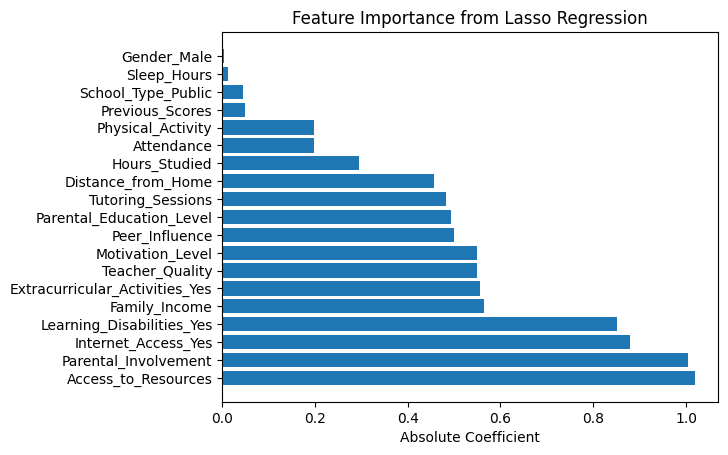

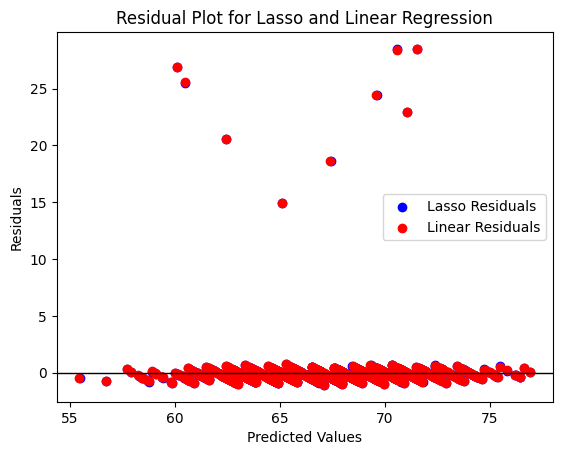

In [113]:
#Plot Feature Importance
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance from Lasso Regression')
plt.show()
##Plot Residuals
residuals_lasso = y_test - y_pred_lasso
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lasso, residuals_lasso, color='blue', label='Lasso Residuals')
plt.scatter(y_pred_lr, residuals_lr, color='red', label='Linear Residuals')
plt.axhline(0, color='black', linewidth=1)
plt.title('Residual Plot for Lasso and Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

##  Discussion and Conclusion
This section provides a discussion of the key learnings from the analysis, potential reasons for model performance, and suggestions for future improvements. The insights derived from this analysis aim to guide future work and understanding of the underlying data and model selection.

### Key Learnings and Takeaways:
1. **Effectiveness of Regularization (Lasso Regression):**

    - Lasso Regression has proven to be effective in this case due to its ability to perform automatic feature selection through L1 regularization. This not only reduces overfitting by penalizing overly complex models but also identifies the most relevant features, as seen in the feature importance plot. Features such as Income and Acces_to_Resources had the highest coefficients, suggesting they were the most influential in predicting the Exam_Score.

2. **Impact of Hyperparameter Tuning:**

    - The hyperparameter tuning (specifically the alpha parameter) was crucial in improving the model's performance. Through GridSearchCV, we identified the best alpha (0.001291549665014884), which balanced regularization with model complexity. The importance of tuning such parameters cannot be overstated, as it significantly improves model accuracy by avoiding underfitting or overfitting.
3. **Linear Regression as a Baseline:**

    - The comparison between Linear Regression and Lasso Regression highlights the importance of regularization in regression tasks, especially when dealing with multiple features. While Linear Regression provided a decent baseline, its performance was inferior to Lasso Regression, which suggests that regularization played a key role in improving the generalization ability of the model.

### Challenges and What Didn’t Work:
1. **Potential Overfitting in Linear Regression:**

    - Even though Linear Regression did not perform poorly, it did show a higher MSE and a slightly lower R² compared to Lasso Regression. This may suggest that the model might have been overfitting to the training data, particularly if there were multicollinearity issues or irrelevant features. However, Linear Regression without regularization doesn't automatically perform feature selection, making it susceptible to the effects of multicollinearity, as seen from the VIF scores.

2. **Multicollinearity and Feature Correlation:**

    - Despite checking for multicollinearity using VIF, there may still be subtle correlations between features that affect the models' performance. Some features, especially those with low coefficients in Lasso, might still carry some predictive value if considered together. More advanced feature engineering or interaction terms might reveal further relationships that could improve performance.

3. **Limited Scope of Evaluation Metrics:**

    - In this analysis, we focused on Mean Squared Error (MSE) and R² as evaluation metrics. While these are standard and effective for regression tasks, there are other metrics (such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE)) that could provide additional insights into the model's predictive accuracy, particularly in terms of error magnitude. Additionally, Cross-Validation ensured that our results were robust, but incorporating more metrics for model evaluation could provide a deeper understanding of performance across different subsets of the data.

### Suggestions for Future Work and Improvements:
1. **Exploring Ridge Regression and ElasticNet:**

    - Ridge Regression (which uses L2 regularization) and ElasticNet (which combines both L1 and L2 regularization) are two other popular regularization techniques that could further improve performance. ElasticNet, in particular, could be beneficial when there are correlations between features, as it combines the benefits of both Lasso and Ridge.
2. **Advanced Feature Engineering:**

    - Although Lasso Regression already performed feature selection, there may still be other hidden relationships between features that could improve model performance. Polynomial features, interaction terms, or even domain-specific knowledge could be incorporated into the feature set to capture more complex patterns in the data.
3. **Data Preprocessing and Scaling:**

    - The dataset might benefit from additional preprocessing steps, such as handling missing values, outliers, or categorical encoding (if not already handled in earlier steps). For instance, some features might require scaling (e.g., normalization or standardization) to ensure that all features are treated equally, especially for models like Lasso and Ridge that are sensitive to the magnitude of features.
4. **Hyperparameter Optimization:**

    - GridSearchCV provided an optimal alpha value, but other models or hyperparameters (such as the number of folds in cross-validation or tuning other Lasso parameters) could be tested in greater depth. Exploring RandomizedSearchCV or Bayesian Optimization for hyperparameter tuning might lead to even better results.
5. **More Robust Model Evaluation:**

    - Although MSE and R² are good indicators, incorporating other metrics like Mean Absolute Error (MAE) or Cross-Validation based evaluation could give a more comprehensive understanding of the model’s performance. Further, learning curves or validation curves could be generated to visualize how the model performance changes with varying amounts of training data or different parameter values.
6. **Handling Imbalanced Data:**

    - While this specific task does not focus on imbalanced data, in cases where class imbalance exists (for classification tasks), metrics like F1-score, ROC-AUC, and Precision-Recall curves would be better suited than traditional accuracy-based metrics. If dealing with imbalanced data in the future, these techniques would help better understand model performance across all classes.
### Final Thoughts:
Overall, the analysis clearly demonstrates the importance of regularization in improving model performance, particularly for datasets with many features. Lasso Regression, with the optimal alpha, outperforms Linear Regression by addressing both overfitting and multicollinearity issues. The performance improvements through hyperparameter tuning and feature selection are clear takeaways, and future work could focus on refining these models even further by exploring additional regularization techniques, improving feature engineering, and experimenting with alternative metrics and evaluations.